In [24]:
import cv2
import numpy as np
import os
import subprocess
import glob
from matplotlib import pyplot as plt
import math
from shapely.geometry import LineString

INPUT_FOLDER = "./screenshots/"
OUTPUT_FOLDER = "./output/"
TEST_IMAGE = "screenshot_straight.png"
TEST_VIDEO = "test_video.mov"
DEBUG = True

def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()
    
def save_image(image, title):
    cv2.imwrite(title, image)
    
def grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if DEBUG:
        plot_image(grayscale_image, "grayscale")
    return grayscale_image

def blur(image):
    blur_image = cv2.GaussianBlur(image, (3,3),0)
    if DEBUG:
        plot_image(blur_image, "blur")
    return blur_image
        
def canny(image):
    canny_image = cv2.Canny(image, 100, 150)
    if DEBUG:
        plot_image(canny_image, "canny")
    return canny_image

def boi(image):
    height = image.shape[0]
    width = image.shape[1]
    side_top_padding = height / 2
    side_bottom_padding = height - 50
    middle_top_padding = height / 2
    inner_top_padding = height * 1 / 3
    inner_bottom_padding = height * 2 / 3
    
    width1_3 = width * 1 / 3
    width2_3 = width * 2 / 3
    width1_2 = width / 2
    
    x1 = [0, side_top_padding]
    x2 = [width1_3, inner_top_padding]
    x3 = [width1_2, middle_top_padding]
    x4 = [width2_3, inner_top_padding]
    x5 = [width, side_top_padding]
    x6 = [width, side_bottom_padding]
    x7 = [width1_2, middle_top_padding]
    x8 = [0, side_bottom_padding]
    
    
    mask = np.zeros_like(image)
    vertices = [np.array([x1,x2,x3,x4, x5, x6, x7, x8], dtype=np.int32)]
    cv2.fillPoly(mask, vertices, 255)
    
    if DEBUG:
        plot_image(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    if DEBUG:
        plot_image(masked_image, "roi")
    return masked_image
        
def roi(image):
    bottom_padding = 375 # Front bumper compensation
    height = image.shape[0]
    width = image.shape[1]
    # FYI, below values are highly dependant on the camera calibration i.e what part of the road is actually being captured
    bottom_left = [0, height-bottom_padding]
    bottom_right = [width, height-bottom_padding]
    top_right = [width*1/3, height*1/3]
    top_left = [width*2/3, height*1/3]
    middle = [width/2, height*2/3]
    vertices = [np.array([bottom_left, bottom_right, top_left, middle, top_right], dtype=np.int32)]
    mask = np.zeros_like(image)  
    cv2.fillPoly(mask, vertices, 255)
    width_padding = -100
    vertices = [np.array([[0,height], [0, height-bottom_padding],[width/2, height - bottom_padding], [0+width_padding, height]], dtype=np.int32)]
    cv2.fillPoly(mask, vertices, 255)
    
    vertices = [np.array([[width,height],[width, height-bottom_padding],[width/2, height - bottom_padding], [width-width_padding, height]], dtype=np.int32)]
    cv2.fillPoly(mask, vertices, 255)

    if DEBUG:
        plot_image(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    if DEBUG:
        plot_image(masked_image, "roi")
    return masked_image
    
def averaged_lines(image, lines, lines_image):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    left = scale(*left, 2)
    right = merge_lines(image, right_lines)
    right = scale(*right, 2)
    l_left = LineString([[left[0],left[1]],[left[2],left[3]]])
    l_right = LineString([[right[0],right[1]],[right[2],right[3]]])
    point = l_left.intersection(l_right)
    x = int(point.x)
    y = int(point.y)
    print(point)
    cv2.line(lines_image, (x, 0), (x, 1000), (255, 255, 255), 3)
    left[2] = x
    left[3] = y
    right[2] = x
    right[3] = y
    return left, right

def scale(x1,y1,x2,y2,factor):
    t0=0.5*(1.0-factor)
    t1=0.5*(1.0+factor)
    x1 = x1 +(x2 - x1) * t0
    y1 = y1 +(y2 - y1) * t0
    x2 = x1 +(x2 - x1) * t1
    y2 = y1 +(y2 - y1) * t1
    return [int(x1),int(y1),int(x2),int(y2)]

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap, avg=False):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        lines = averaged_lines(image, lines, lines_image) if avg else lines[:, 0]
        #lines = averaged_lines(image, lines)
        #lines = lines[:, 0]
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (255, 255, 255), 20)
        if DEBUG:
            plot_image(lines_image, "lines")
    return lines_image

def combine_images(roi_image, initial_image, α=1, β=1, λ=0.0):
    roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGRA2BGR)
    initial_image = cv2.cvtColor(initial_image, cv2.COLOR_BGRA2BGR)
    combined_image = cv2.addWeighted(roi_image, α, initial_image, β, λ)
    if DEBUG:
        plot_image(combined_image, "combined")
    return combined_image

def find_street_lanes(image):
    grayscale_image = grayscale(image)
    blur_image = blur(grayscale_image)
    canny_image = canny(blur_image)
    blur2_image = blur(canny_image)
    roi_image = boi(blur2_image)
    hough_lines_image = hough_lines(roi_image, 0.9, np.pi/180, 100, 100, 50)
    grayscale_image2 = grayscale(hough_lines_image)
    blur_image2 = blur(grayscale_image2)
    canny_image2 = canny(blur_image2)
    blur2_image2 = blur(canny_image2)
    hough_lines_image2 = hough_lines(blur2_image2, 0.9, np.pi/180, 100, 100, 50)
    grayscale_image3 = grayscale(hough_lines_image2)
    blur_image3 = blur(grayscale_image2)
    canny_image3 = canny(blur_image2)
    blur2_image3 = blur(canny_image2)
    hough_lines_image3 = hough_lines(blur2_image3, 0.9, np.pi/180, 100, 100, 50, True)
    #final_image = combine_images(roi_image2, hough_lines_image3)
    final_image = combine_images(image, hough_lines_image3)
    return final_image

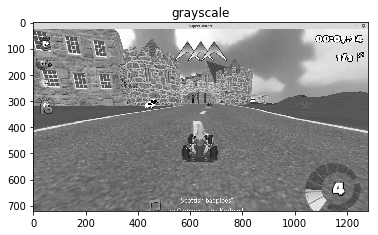

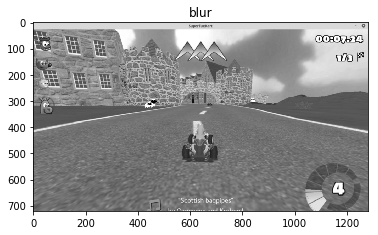

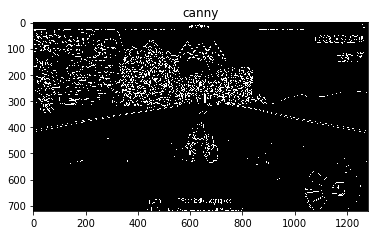

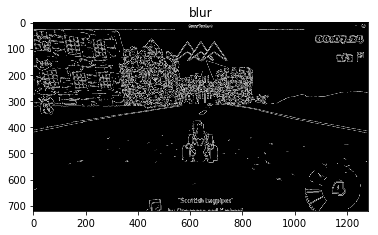

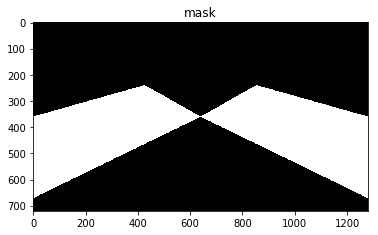

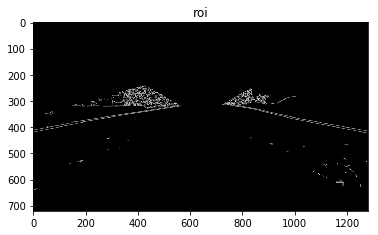

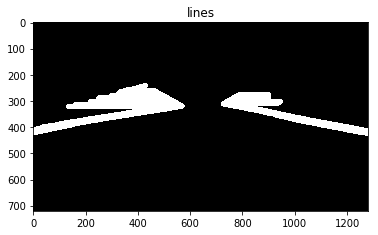

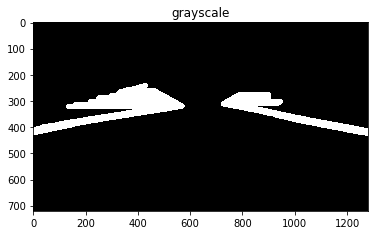

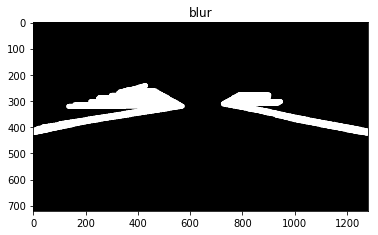

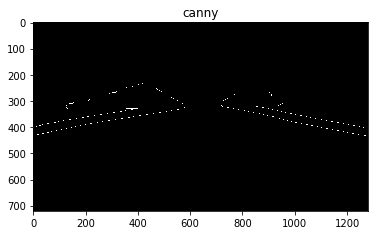

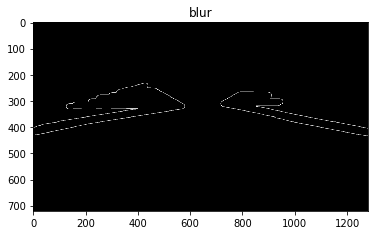

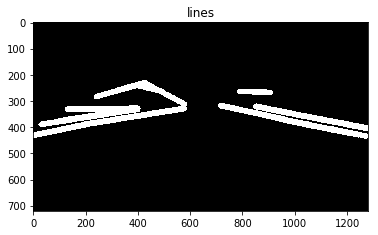

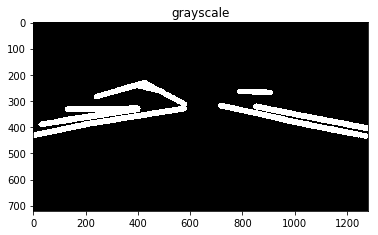

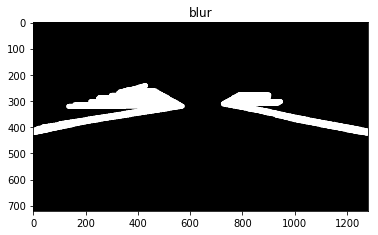

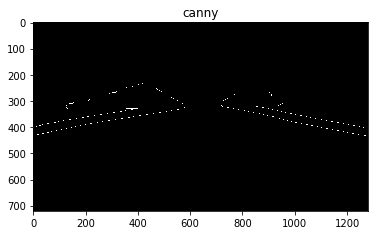

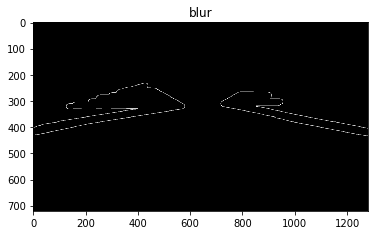

POINT (596.380452158027 284.7773464261247)


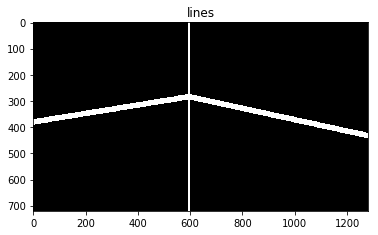

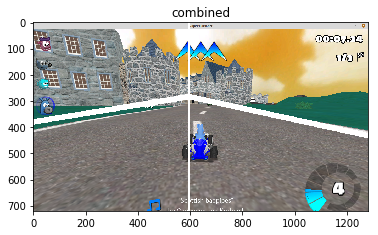

In [25]:
#TODOOOO: try with this from scratch: https://github.com/naokishibuya/car-finding-lane-lines
#TODOO: beim zweiten hough lines mit averaged machen
TEST_IMAGE = '1569243479642.png'
test_image = cv2.imread(INPUT_FOLDER + TEST_IMAGE)
street_lanes = find_street_lanes(test_image)
save_image(street_lanes, OUTPUT_FOLDER + TEST_IMAGE)

In [26]:
# Test Image
DEBUG=False
for filename in os.listdir(INPUT_FOLDER):
    try:
        TEST_IMAGE = filename
        test_image = cv2.imread(INPUT_FOLDER + TEST_IMAGE)
        if test_image is None:
            continue
            pass
        street_lanes = find_street_lanes(test_image)
        save_image(street_lanes, OUTPUT_FOLDER + TEST_IMAGE)
    except OverflowError:
        print(TEST_IMAGE)

POINT (703.2401902497027 299.0011890606421)
POINT (657.3038961038961 319.3246753246754)
POINT (506.9737384140062 286.5563851699279)
POINT (790.5090813371939 289.781521453014)
POINT (650.3985157432091 306.579724764032)
POINT (748.7362773421378 312.0841931489888)
POINT (724.8392007611799 305.8801141769743)
POINT (442.5391923990499 313.1828978622328)
POINT (622.2139352306183 333.2384690873405)
POINT (855.5039836567927 313.9979570990807)
POINT (705.2167300380229 305.5038022813688)
POINT (365.5602704593146 297.6777803683842)
POINT (588.6866791744841 309.343339587242)
POINT (680.2891421715657 308.3323335332933)
POINT (752.1083705573898 299.1464362012041)
POINT (779.6046100782366 308.6666105829898)
POINT (620.8838835583022 315.6513254187673)
POINT (599.1608849747611 266.9455482762324)
POINT (636.1694185211774 295.8435032304379)
POINT (812.9035812672176 309.297520661157)
POINT (614.5142036714183 290.1117834068301)
POINT (309.8296733714707 262.4930799040413)
POINT (687.933791124321 326.59936455

In [ ]:
# Test Video
capture = cv2.VideoCapture(INPUT_FOLDER + TEST_VIDEO)
while True:
    _, frame = capture.read()
    if frame is not None:
        street_lanes = find_street_lanes(frame)
        cv2.imshow("video", street_lanes)
        cv2.waitKey(20)
    else:
        break
capture.release()
cv2.destroyAllWindows()
exit()